In [1]:
import os
import sys
sys.path.append('../src')
sys.path.append('../utility')
import datetime
import time
import importlib
from collections import Counter

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt

import japanize_matplotlib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
import neologdn

from bidirectional_map import BidiMap
import similarity as sim
import macd
import create_wordcloud as wc
importlib.reload(macd)
importlib.reload(sim)
importlib.reload(wc)

from comment_preprocessing import reformat_time
import matplotlib_wrapper as mw
importlib.reload(mw)

<module 'matplotlib_wrapper' from '../utility/matplotlib_wrapper.py'>

In [2]:
video_id_list = [
    "RPqSnJez-YI",
    "-sJSuDcPKRw",
    "HCsLM8I-ZEg",
    "c6od-g02MLk"
]
video_id = video_id_list[0]
file = os.path.join("../data/comments", video_id_list[0]+".tsv")
print(file)
df = pd.read_csv(file, sep="\t")
df = df[~df.publishedAt.str.startswith('-')]
df.index = pd.to_timedelta(df.apply(lambda x: reformat_time(x.publishedAt), axis=1))
df['freq'] = 1

../data/comments/RPqSnJez-YI.tsv


### コメントデータの前処理を行う
- neologdn方式で文字列を正規化する

In [3]:
df['displayMessage'] = df.apply(lambda x: neologdn.normalize(x.displayMessage, repeat=2), axis=1)

# 一定間隔でコメント頻度をリサンプリングして分析に用いる
- 今回は動画が長いので60秒間隔

In [4]:
df['counter'] = df.apply(lambda x: Counter([x.displayMessage]), axis=1)
resampled = df.resample("60s")

resampled_freq = resampled['freq'].sum()
resampled_counter = resampled['counter'].sum()
df_resampled = pd.concat([resampled_freq, resampled_counter], axis=1)
df_resampled['total_sec'] = df_resampled.index.total_seconds().astype(int)
df_resampled['url'] = df_resampled['total_sec'].apply(lambda t: 'https://www.youtube.com/watch?v=%s&t=%s' % (video_id, t))
# リサンプリングしたtimedeltaとそのインデックスの双方向map
time_mapper = BidiMap(resampled_freq.index.to_series().reset_index(drop=True).to_dict())

In [5]:
df_resampled.head()

,freq,counter,total_sec,url
00:00:01,273,"{'当たっていい当たっていい': 1, 'やあ': 151, 'なにやってんだよ': 1, ...",1,https://www.youtube.com/watch?v=RPqSnJez-YI&t=1
00:01:01,225,"{'やあ': 48, '日本テレコム': 7, '初見です': 1, '加藤純一さんがオンラ...",61,https://www.youtube.com/watch?v=RPqSnJez-YI&t=61
00:02:01,241,"{'やあ': 21, '久しぶりのマリメ': 1, 'だっせー': 1, 'むっず': 1,...",121,https://www.youtube.com/watch?v=RPqSnJez-YI&t=121
00:03:01,207,"{'有能': 16, '猫マリオ知らんもんな': 1, 'おい純、栄冠はどうなったんだ今日や...",181,https://www.youtube.com/watch?v=RPqSnJez-YI&t=181
00:04:01,243,"{'優しいな': 1, '有能': 12, 'ありがたいねえ': 1, 'チュートリアルあっ...",241,https://www.youtube.com/watch?v=RPqSnJez-YI&t=241


# コメント頻度の時系列データより，MACDを計算する

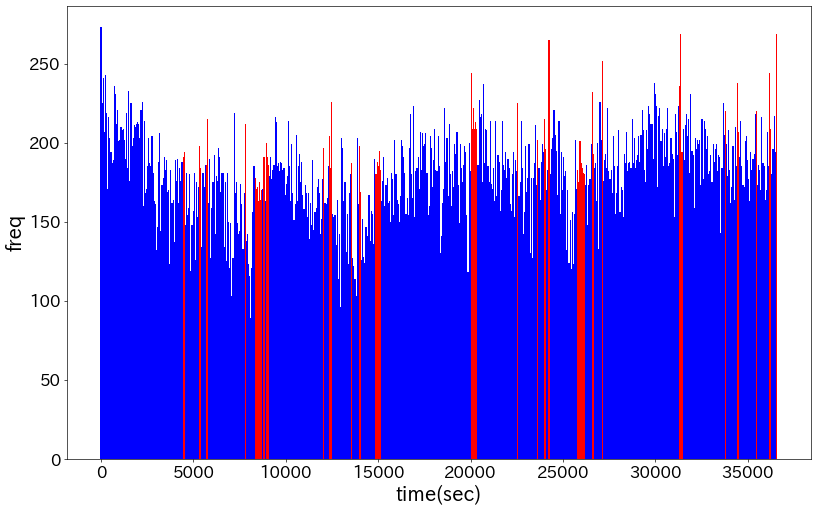

In [6]:
x = df_resampled['total_sec'].values
y = df_resampled['freq'].values
macd_hist = macd.calc_macd(x, y, f=26, s=12, t=9)
df_resampled = pd.merge(df_resampled[['counter', 'total_sec', 'url']], macd_hist, left_on="total_sec", right_index=True)

mw.bar_timeseries(x,y, label=['r' if hist > 3.0 else 'b' for hist in macd_hist['hist']], width=60)

In [7]:
df_resampled.head()

,counter,total_sec,url,freq,ema_12,ema_26,macd,signal,hist
00:00:01,"{'当たっていい当たっていい': 1, 'やあ': 151, 'なにやってんだよ': 1, ...",1,https://www.youtube.com/watch?v=RPqSnJez-YI&t=1,273,273.000000,273.000000,0.000000,0.000000,0.000000
00:01:01,"{'やあ': 48, '日本テレコム': 7, '初見です': 1, '加藤純一さんがオンラ...",61,https://www.youtube.com/watch?v=RPqSnJez-YI&t=61,225,247.000000,248.076923,-1.076923,-0.598291,-0.478632
00:02:01,"{'やあ': 21, '久しぶりのマリメ': 1, 'だっせー': 1, 'むっず': 1,...",121,https://www.youtube.com/watch?v=RPqSnJez-YI&t=121,241,244.658199,245.534253,-0.876055,-0.712128,-0.163926
00:03:01,"{'有能': 16, '猫マリオ知らんもんな': 1, 'おい純、栄冠はどうなったんだ今日や...",181,https://www.youtube.com/watch?v=RPqSnJez-YI&t=181,207,232.770977,234.761760,-1.990783,-1.145277,-0.845506
00:04:01,"{'優しいな': 1, '有能': 12, 'ありがたいねえ': 1, 'チュートリアルあっ...",241,https://www.youtube.com/watch?v=RPqSnJez-YI&t=241,243,235.550166,236.672242,-1.122076,-1.138375,0.016299


# シーンごとの単語の出現頻度をベクトル化して，類似度を算出し，分析に用いる

In [8]:
# 15秒ごとの単語の出現頻度をベクトル化する
V = DictVectorizer()
X = V.fit_transform(resampled_counter)
# V.get_feature_names()

### コメントベクトルを次元削減

In [9]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

print(X.shape)
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(X)
print(X_reduced.shape)

# 各コメントベクトル間の類似度を計算する
cos_sim = sim.cos_sims(X)
cos_sim.shape

(610, 60899)
(610, 2)


(610, 610)

In [10]:
df_sim = []
for k in time_mapper.kv.keys():
  d = sim.get_similar_item_info(cos_sim, k, time_mapper, n=6)
  df_sim.append(d[1:])
df_sim = pd.concat(df_sim, axis=0)
df_sim.to_csv(os.path.join('../data', 'comment_similarity_%s.tsv' % video_id), sep='\t', index=False)

### グラフを描画する

In [28]:
df_sim.describe()

,node1,node2,value
count,3050.000000,3050.000000,3050.000000
mean,18271.000000,16389.459016,0.435601
std,10567.228204,10979.350070,0.218998
min,1.000000,1.000000,0.034704
25%,9121.000000,7561.000000,0.257954
50%,18271.000000,13981.000000,0.396287
75%,27421.000000,26281.000000,0.603245
max,36541.000000,36541.000000,0.945046


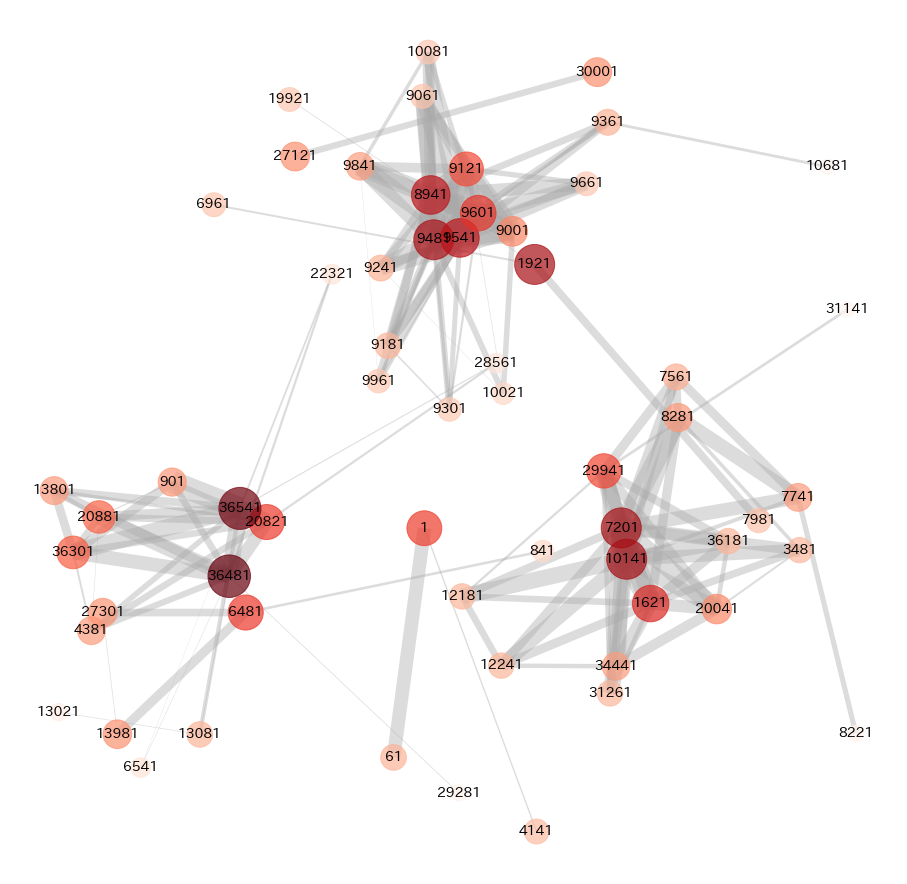

In [44]:
import draw_network as dn
importlib.reload(dn)

df_sim = pd.read_csv(os.path.join('../data', 'comment_similarity_%s.tsv' % video_id), sep='\t')
df_sim['target'] = pd.to_timedelta(df_sim['target']).apply(lambda t: t.total_seconds()).astype(int)
df_sim['item'] = pd.to_timedelta(df_sim['item']).apply(lambda t: t.total_seconds()).astype(int)

df_sim.rename(columns={'target':'node1', 'item':'node2', 'similarity':'value'}, inplace=True)
edge_threshold = 0.8

dn.plot_network(df_sim, edge_threshold=edge_threshold, fig_size=(16, 16), save_path='', edge_weight=200)

In [46]:
df_resampled[df_resampled['total_sec'].isin(time_list)]

,counter,total_sec,url,freq,ema_12,ema_26,macd,signal,hist
00:27:01,"{'向き合え': 1, '時間かkりすぎ': 1, 'うまくなってる': 1, 'うっま':...",1621,https://www.youtube.com/watch?v=RPqSnJez-YI&t=...,225,206.807693,208.206308,-1.398616,-2.081983,0.683368
00:32:01,"{'そこ早くいかんと間に合わなそう': 1, 'ぶっささり': 1, 'うっざ': 1, '...",1921,https://www.youtube.com/watch?v=RPqSnJez-YI&t=...,212,207.436888,207.901908,-0.465020,-1.452865,0.987844
02:29:01,"{'草': 61, '草w': 6, '幅跳び全一': 1, 'うぃっひ': 1, '草使う...",8941,https://www.youtube.com/watch?v=RPqSnJez-YI&t=...,200,172.132115,164.744393,7.387721,3.687300,3.700422
02:49:01,"{'チー草「牛」': 1, 'へた': 1, '草': 7, '衛門もいよいよ終わりだな':...",10141,https://www.youtube.com/watch?v=RPqSnJez-YI&t=...,214,186.598396,182.378187,4.220209,4.619969,-0.399760
10:08:01,"{'一緒に泳いでる': 1, 'あたおか': 1, 'うっま': 44, 'お前がニコ生で作...",36481,https://www.youtube.com/watch?v=RPqSnJez-YI&t=...,194,197.832488,194.833847,2.998641,1.761523,1.237119


# グラフ描画結果で分離されたクラスタの主要ノード比較する
- ワードクラウド形式で比較する

time0 days 00:27:01: https://www.youtube.com/watch?v=RPqSnJez-YI&t=1621


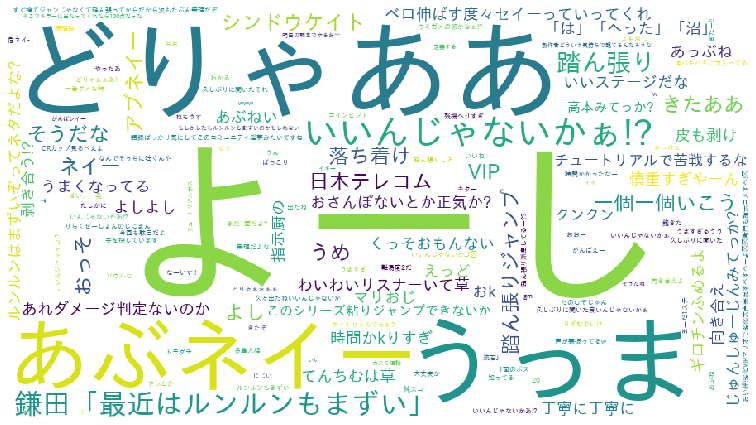

time0 days 00:32:01: https://www.youtube.com/watch?v=RPqSnJez-YI&t=1921


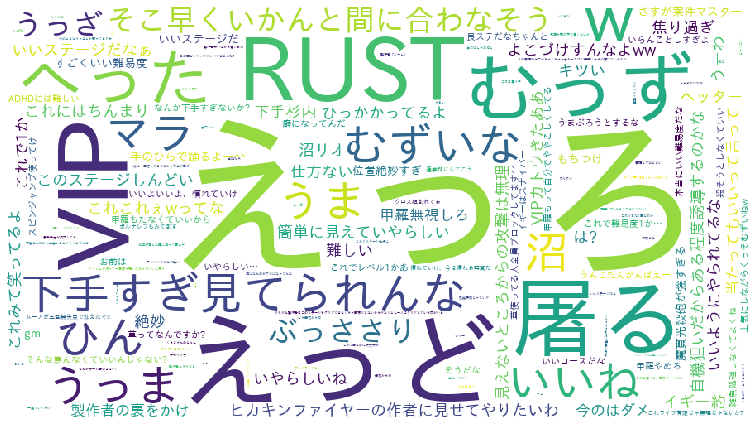

time0 days 02:29:01: https://www.youtube.com/watch?v=RPqSnJez-YI&t=8941


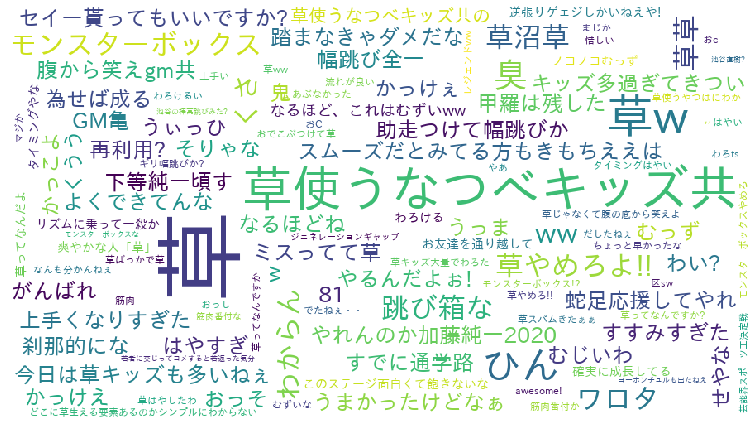

time0 days 02:49:01: https://www.youtube.com/watch?v=RPqSnJez-YI&t=10141


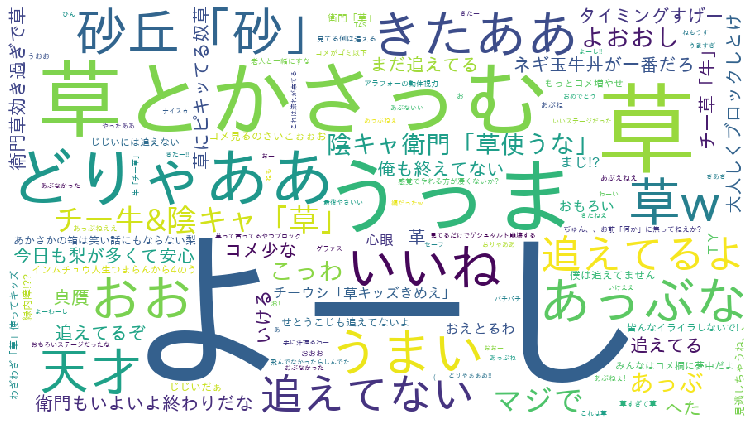

time0 days 10:08:01: https://www.youtube.com/watch?v=RPqSnJez-YI&t=36481


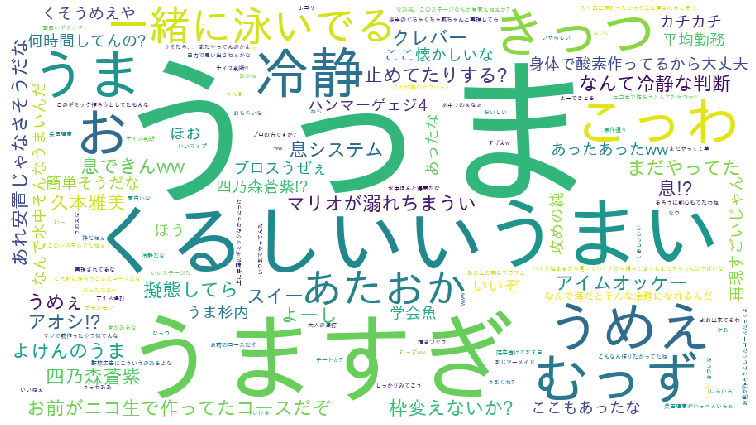

In [48]:
import pandas.tseries.offsets as offsets
time_list = [36481, 10141, 1621, 8941, 1921]

# 盛り上がったシーンの前後t_offset間のコメントを利用する
t_offset = 30
for t, row in df_resampled[df_resampled['total_sec'].isin(time_list)].iterrows():
    url = df_resampled.loc[t].url
    print('time{0}: {1}'.format(t, url))
    wc.create_from_dict(sum(resampled_counter[t-offsets.Second(t_offset):t+offsets.Second(t_offset)], Counter()))    